In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import json

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from utils.dataset import FreiHAND
from utils.model import ShallowUNet
from utils.trainer import Trainer
from utils.prep_utils import (
    blur_heatmaps,
    IoULoss,
    COLORMAP,
    N_KEYPOINTS,
    N_IMG_CHANNELS,
    get_norm_params,
    show_data,
)

### Train Parameters

In [9]:
config = {
    "data_dir": "data/FreiHAND_pub_v2",
    "epochs": 1000,
    "batch_size": 48,
    "batches_per_epoch": 50,
    "batches_per_epoch_val": 20,
    "learning_rate": 0.1,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

## Data

In [10]:
train_dataset = FreiHAND(config=config, set_type="train")
train_dataloader = DataLoader(
    train_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

val_dataset = FreiHAND(config=config, set_type="val")
val_dataloader = DataLoader(
    val_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

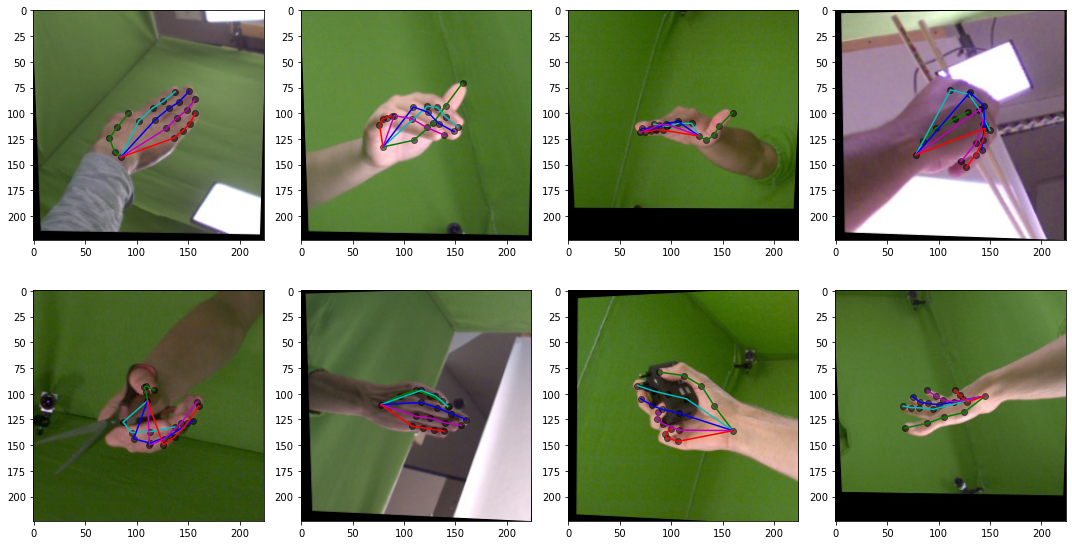

In [5]:
# visualize random batch of data train samples + labels
show_data(train_dataset, n_samples=8)

## Model

In [11]:
model = ShallowUNet(N_IMG_CHANNELS, N_KEYPOINTS)
model = model.to(config["device"])

criterion = IoULoss()
optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=20, verbose=True, threshold=0.00001
)

## Training

In [12]:
trainer = Trainer(model, criterion, optimizer, config, scheduler)
model = trainer.train(train_dataloader, val_dataloader)

Epoch: 1/1000, Train Loss=0.9929370284, Val Loss=0.9929751328
Epoch: 2/1000, Train Loss=0.992846489, Val Loss=0.9928381755
Epoch: 4/1000, Train Loss=0.9925988913, Val Loss=0.9926051639
Epoch: 5/1000, Train Loss=0.9924759269, Val Loss=0.992415028
Epoch: 6/1000, Train Loss=0.9922805429, Val Loss=0.9922484897
Epoch: 7/1000, Train Loss=0.992020309, Val Loss=0.9919465638
Epoch: 8/1000, Train Loss=0.9916339517, Val Loss=0.991668494
Epoch: 9/1000, Train Loss=0.9912390709, Val Loss=0.9912366157
Epoch: 10/1000, Train Loss=0.9905645847, Val Loss=0.9903384731
Epoch: 11/1000, Train Loss=0.9896404147, Val Loss=0.9894862998
Epoch: 12/1000, Train Loss=0.9876861572, Val Loss=0.9875127276
Epoch: 13/1000, Train Loss=0.9837049246, Val Loss=0.9847518518
Epoch: 14/1000, Train Loss=0.9781317115, Val Loss=0.9767943621
Epoch: 15/1000, Train Loss=0.9531974196, Val Loss=0.9546156838
Epoch: 16/1000, Train Loss=0.9245086908, Val Loss=0.9356913936
Epoch: 18/1000, Train Loss=0.9158593416, Val Loss=0.908727626
Epoch

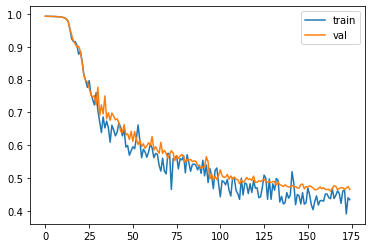

In [13]:
plt.plot(trainer.loss["train"], label="train")
plt.plot(trainer.loss["val"], label="val")
plt.legend()
plt.show()